In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import gymnasium as gym
import scipy.signal
import matplotlib.pyplot as plt

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

# Hyperparameters & Environment

In [2]:
# Environment Hyperparameters
ENV_DELTA_T = 0.1
ENV_MAX_STEPS = 100
ENV_LATENCY = 0
# ENV ACTIONS
ENV_A_UPPER_BOUND = np.pi
ENV_A_LOWER_BOUND = 0


# Hyperparameters of the PPO algorithm
EPISODES = 100 # Number of episodes to run
GAMMA = 0.95 # Discount factor
CLIP_RATIO = 0.3 # Clipping parameter epsilon
POLICY_LEARNING_RATE = 5e-4 # Learning rate of policy optimizer
VALUE_FUNCTION_LEARNING_RATE = 1e-3 # Learning rate of value function optimizer
TRAIN_POLICY_ITERATIONS = 80 # Number of iterations of training policy per episode
TRAIN_VALUE_ITERATIONS = 80 # Number of iterations of training value function per episode
LAMBDA = 0.95 # Lambda parameter for GAE
TARGET_KL = 0.025 # Desired KL divergence between old and new policy
HIDDEN_LAYER_SIZES = (256, 256) # Size of hidden layers of neural networks
# actions & observations
NUM_ACTIONS = 2 
NUM_OBSERVATIONS = 2*ENV_LATENCY if ENV_LATENCY > 0 else 3

# True if you want to render the environment
RENDER = False

## Environment

In [3]:
env = SimpleControlledFixedEnv(noise_model='sinusoidal', sinusoidal_components=1, seed = 1337)
# print(env.delta_t)
# env.max_t = 2
env.delta_t = ENV_DELTA_T
env.fixed_error_ctrl_pump = [0, 0, 0, 0]
env.fixed_error_ctrl_alice = [np.pi, 0, 0, 0]
env.fixed_error_ctrl_bob = [0, 0, 0, 0]
env.fixed_errors_flags = [True, True, True, True, 
                          False, True, True, True, 
                          True, True, True, True]
env.latency = ENV_LATENCY
env.max_t = ENV_MAX_STEPS*ENV_DELTA_T

## Env testing

Base reward: -35.374157190964


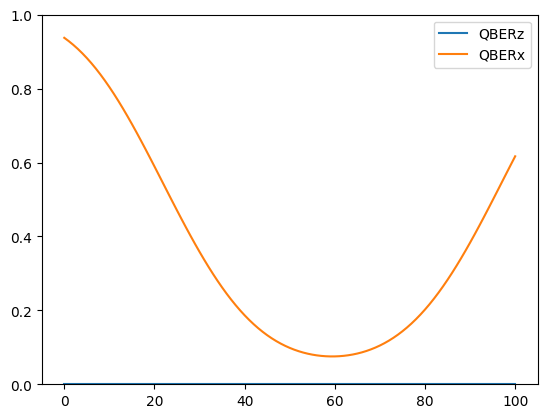

In [4]:
state = env.reset()
done = False
baseline_reward = 0
while not done:
    state, reward, done = env.step()
    baseline_reward += reward
    if done:
        break

plt.ylim(0, 1)
plt.plot(env.qber_history)
plt.legend(['QBERz', 'QBERx'])
print("Base reward:", baseline_reward)

# Definitions

In [ ]:
def actor_network(input_shape, action_dim):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    mean = tf.keras.layers.Dense(action_dim, activation=None)(x)
    log_std = tf.keras.layers.Dense(action_dim, activation=None)(x)
    std = tf.exp(log_std)
    return tf.keras.Model(inputs=inputs, outputs=[mean, std])

In [5]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

# Sample action from actor
@tf.function
def sample_action(observation):
    mean, std_dev = actor(observation)
    action = mean + tf.random.normal(tf.shape(mean)) * std_dev
    return action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + CLIP_RATIO) * advantage_buffer,
            (1 - CLIP_RATIO) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [6]:
buffer = Buffer(NUM_OBSERVATIONS, ENV_MAX_STEPS+1)
# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(NUM_OBSERVATIONS,), dtype="float32")
logits = mlp(observation_input, list(HIDDEN_LAYER_SIZES) + [NUM_ACTIONS])
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(mlp(observation_input, list(HIDDEN_LAYER_SIZES) + [1]), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=POLICY_LEARNING_RATE)
value_optimizer = keras.optimizers.Adam(learning_rate=VALUE_FUNCTION_LEARNING_RATE)

# Initialize the episode return and episode length
episode_return, episode_length = 0, 0
prev_observation, _ = env.reset()
prev_observation.append(env.get_info())
# for latency
if isinstance(prev_observation[0], list):
    prev_observation = np.concatenate(prev_observation).flatten().tolist()

2024-07-16 16:47:19.377782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training Loop

In [7]:
def average_last_n(lst, n=100):
    if len(lst) < n:
        return None
    return sum(lst[-n:])/n

In [8]:
from tqdm import tqdm
pbar = tqdm(range(EPISODES))

rewards = []
ep_rewards = []

# Iterate over the number of epochs
for epoch in pbar:    
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0
    # Iterate over the steps of each epoch
    for t in range(ENV_MAX_STEPS):
        # Get the logits, action, and take one step in the environment
        prev_observation = tf.expand_dims(
            tf.convert_to_tensor(prev_observation), 0
        )
        logits, action = sample_action(prev_observation)
        # print(action[0].numpy())
        observation_new, reward, done = env.step(a_alice=[action[0].numpy(), 0, 0, 0])
        episode_return += reward
        episode_length += 1
        # for latency
        if isinstance(observation_new[0], list):
            observation_new = np.concatenate(observation_new).flatten().tolist()
        observation_new.append(env.get_info())

        # Get the value and log-probability of the action
        value_t = critic(prev_observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(prev_observation, action, reward, value_t, logprobability_t)

        # Update the observation
        prev_observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == ENV_MAX_STEPS - 1):
            if done:
                last_value = 0     
            else:
                prev_observation = tf.expand_dims(
                    tf.convert_to_tensor(prev_observation), 0
                ) 
                last_value = critic(prev_observation)
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            ep_rewards.append(episode_return)
            sum_length += episode_length
            num_episodes += 1
            # save qber before reset
            last_qber = env.qber_history
            prev_observation, _ = env.reset()
            prev_observation.append(env.get_info())
            # for latency
            if isinstance(prev_observation[0], list):
                prev_observation = np.concatenate(prev_observation).flatten().tolist()
            episode_return, episode_length = 0, 0
            rewards.append(sum_return / num_episodes)

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(TRAIN_POLICY_ITERATIONS):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * TARGET_KL:
            # Early Stopping
            break

    # Update the value function
    for _ in range(TRAIN_VALUE_ITERATIONS):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    pbar.set_description(f"Mean Return: {sum_return / num_episodes:.2f}. Mean Length: {sum_length / num_episodes:.2f} Baseline: {baseline_reward:.2f} Last (5): {average_last_n(ep_rewards, 5)}")

  0%|          | 0/100 [00:00<?, ?it/s]


InvalidArgumentError: Value for attr 'TI' of float is not in the list of allowed values: uint8, int8, int32, int64
	; NodeDef: {{node OneHot}}; Op<name=OneHot; signature=indices:TI, depth:int32, on_value:T, off_value:T -> output:T; attr=axis:int,default=-1; attr=T:type; attr=TI:type,default=DT_INT64,allowed=[DT_UINT8, DT_INT8, DT_INT32, DT_INT64]> [Op:OneHot]

# Plots

## Rewards

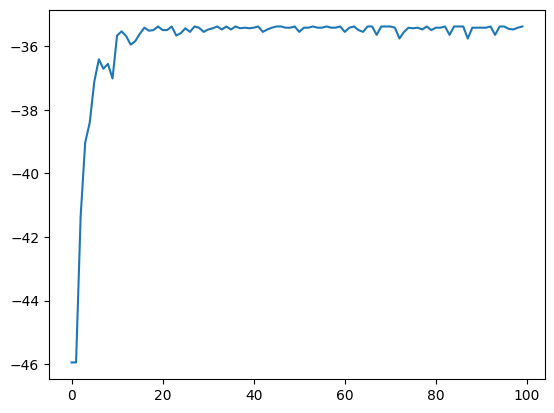

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards)

## QBERs

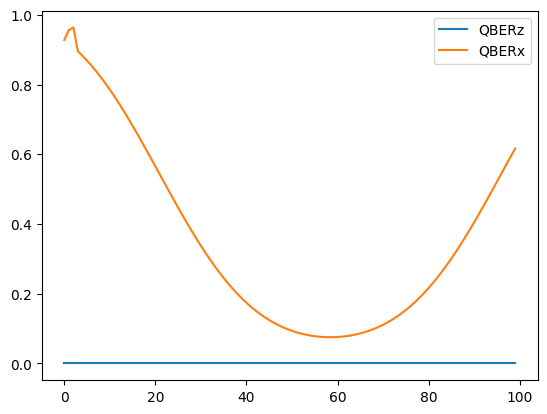

In [ ]:
done = False
# env = reinit_env()
prev_observation, _ = env.reset()
prev_observation.append(env.get_info())
episode_return, episode_length = 0, 0
______plot_qbers = []

while not done:
    # Convert observation to tensor and expand dimensions for the model
    if isinstance(prev_observation[0], list):
        prev_observation = np.concatenate(prev_observation).flatten().tolist()
    prev_observation = tf.expand_dims(tf.convert_to_tensor(prev_observation), 0)
    
    # Sample action from the current policy
    logits, action = sample_action(prev_observation)
    
    # Take a step in the environment
    observation_new, reward, done = env.step(a_alice=[action[0].numpy(), 0, 0, 0])

    ______plot_qbers.append(observation_new)

    episode_return += reward
    episode_length += 1
    
    # Update observation
    prev_observation=[]
    prev_observation = observation_new.copy()
    prev_observation.append(env.get_info())

plt.figure()
plt.clf()
plt.plot(______plot_qbers)
plt.legend(["QBERz", "QBERx", "time shouldn't be here!"])